# Set up a simple training loop

In [1]:
from utils import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt; plt.style.use('dark_background')

In [ ]:
N_SAMPLES = 120
# quantization parameters
EPSI = 0.5 # quantization step
MAX_SIG = 2.5 # maximum value of the signal (symmetric around 0)
NLEVELS = 2*int(MAX_SIG/EPSI) + 1 # number of quantization levels
LEVELS = th.tensor([i*EPSI for i in range(-int(MAX_SIG/EPSI), 1)] + [i*EPSI for i in range(1, int(MAX_SIG/EPSI)+1)])
print(f"Quantization step: {EPSI}, Number of levels: {NLEVELS}, \nLEVELS: {LEVELS}")
assert len(LEVELS) == NLEVELS
# training parameters
N_EPOCHS = 100
BATCH_SIZE = 32
LR = 3e-4
LATENT_DIM = 16
N_HIDDEN = 128
MSE_LAMBDA = th.linspace(0.1, 1e-5, N_EPOCHS)
# dataset parameters
N_DATASET = 20_000
N_FREQS = 4
# soft quantization parameters
TEMPS = th.linspace(0.1, 1e-3, N_EPOCHS)

Quantization step: 0.5, Number of levels: 11, 
LEVELS: tensor([-2.5000, -2.0000, -1.5000, -1.0000, -0.5000,  0.0000,  0.5000,  1.0000,
         1.5000,  2.0000,  2.5000])


In [3]:
# architecture
class Net(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=128):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            # nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x): return self.fc(x)

In [4]:
# create a dataset of random signals
class SigDS(Dataset):
    def __init__(self, n_ds):
        self.n_ds = n_ds
        self.data = th.stack([create_random_signal(N_SAMPLES, N_FREQS) for _ in range(n_ds)])
    def __len__(self): return self.n_ds
    def __getitem__(self, idx): return self.data[idx]

ds = SigDS(N_DATASET)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

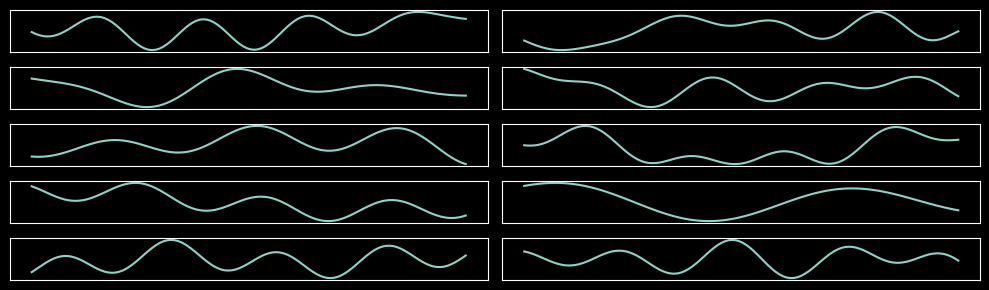

In [5]:
# plot 10 random signals
plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(ds[i])
    plt.xticks([]), plt.yticks([])
plt.tight_layout(), plt.show();

In [6]:
# training loop
enc = Net(N_SAMPLES, LATENT_DIM, N_HIDDEN)
dec = Net(LATENT_DIM, N_SAMPLES, N_HIDDEN)
opt = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=LR)

mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()
H_loss = HLoss2(LEVELS, TEMPS[0])

lmses, lL1s, lHs = [], [], []
for epoch in (range(N_EPOCHS)):
    elmse, elL1, elH = 0, 0, 0
    for x in dl:
        opt.zero_grad()

        x̂ = dec(enc(x)) # forward pass

        #losses
        lmse = mse_loss(x̂, x)
        lL1 = l1_loss(x̂, x)

        H_loss.temperature = TEMPS[epoch] #set temperature
        lH = H_loss(x̂, x)

        elmse += lmse.item()
        elL1 += lL1.item()
        elH += lH.item()

        loss = lH + MSE_LAMBDA[epoch]*lmse 
        loss.backward()

        opt.step()

    lmses.append(elmse/len(dl))
    lL1s.append(elL1/len(dl))
    lHs.append(elH/len(dl))

    print(f'ep {epoch} -> mse:{lmses[-1]:.4f}, L1:{lL1s[-1]:.4f}, H:{lHs[-1]:.4f}   |  temp: {H_loss.temperature:.4f}, mse_lambda : {MSE_LAMBDA[epoch]:.4f}')

ep 0 -> mse:0.5310, L1:0.5091, H:1.5992   |  temp: 0.1000, mse_lambda : 0.1000
ep 1 -> mse:0.1866, L1:0.3006, H:0.6213   |  temp: 0.0990, mse_lambda : 0.0990
ep 2 -> mse:0.1820, L1:0.2918, H:0.5080   |  temp: 0.0980, mse_lambda : 0.0980
ep 3 -> mse:0.1802, L1:0.2887, H:0.4769   |  temp: 0.0970, mse_lambda : 0.0970
ep 4 -> mse:0.1764, L1:0.2845, H:0.4529   |  temp: 0.0960, mse_lambda : 0.0960
ep 5 -> mse:0.1727, L1:0.2788, H:0.4132   |  temp: 0.0950, mse_lambda : 0.0949
ep 6 -> mse:0.1690, L1:0.2725, H:0.3788   |  temp: 0.0940, mse_lambda : 0.0939
ep 7 -> mse:0.1641, L1:0.2681, H:0.3725   |  temp: 0.0930, mse_lambda : 0.0929
ep 8 -> mse:0.1626, L1:0.2660, H:0.3623   |  temp: 0.0920, mse_lambda : 0.0919
ep 9 -> mse:0.1606, L1:0.2646, H:0.3558   |  temp: 0.0910, mse_lambda : 0.0909
ep 10 -> mse:0.1624, L1:0.2655, H:0.3476   |  temp: 0.0900, mse_lambda : 0.0899
ep 11 -> mse:0.1617, L1:0.2665, H:0.3463   |  temp: 0.0890, mse_lambda : 0.0889
ep 12 -> mse:0.1624, L1:0.2667, H:0.3391   |  temp

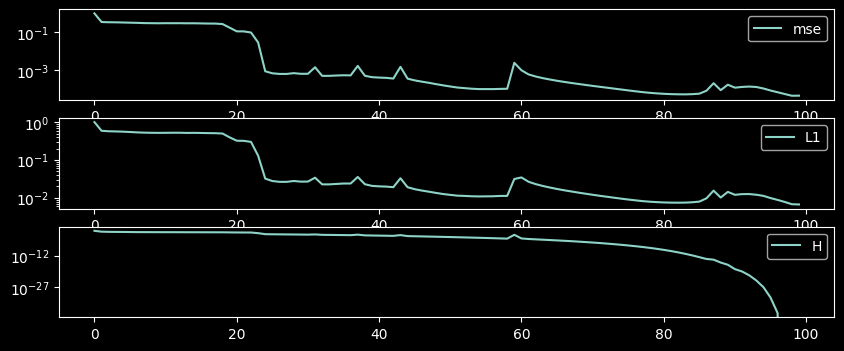

train losses: mse:4.7375e-05, L1:6.6938e-03, H:0.0000e+00


In [7]:
# plot losses
lmses, lL1s, lHs =  th.tensor(lmses), th.tensor(lL1s), th.tensor(lHs)
lmses = lmses/th.max(lmses)
lL1s = lL1s/th.max(lL1s)
lHs = lHs/th.max(lHs)
plt.figure(figsize=(10, 4))
plt.subplot(3,1, 1)
plt.plot(lmses, label='mse')
plt.yscale('log')
plt.legend()
plt.subplot(3,1, 2)
plt.plot(lL1s, label='L1')
plt.yscale('log')
plt.legend()
plt.subplot(3,1, 3)
plt.plot(lHs, label='H')
plt.yscale('log')
plt.legend()
plt.show()
print(f'train losses: mse:{lmses[-1]:.4e}, L1:{lL1s[-1]:.4e}, H:{lHs[-1]:.4e}')

In [8]:
# evaluate on unseen data
test_in = SigDS(100).data
test_out = dec(enc(test_in))
tmse_loss = mse_loss(test_out, test_in)
tL1_loss = l1_loss(test_out, test_in)
tH_loss = H_loss(test_out, test_in)
print(f'test losses: mse:{tmse_loss:.4e}, L1:{tL1_loss:.4e}, H:{tH_loss:.4e}')

test losses: mse:2.1540e-05, L1:3.1425e-03, H:0.0000e+00


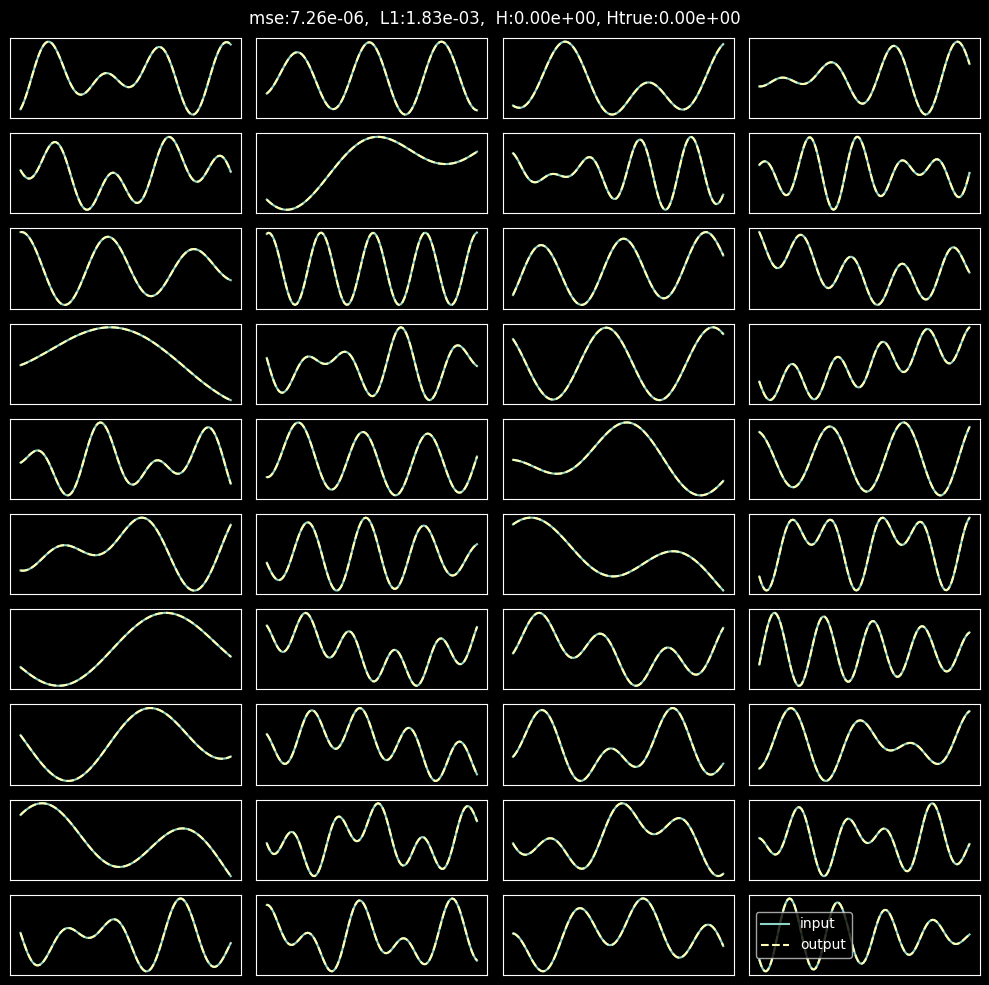

In [9]:
# compare input and output
plt.figure(figsize=(10, 10))
NPLOTS = 40
err = th.zeros(NPLOTS, 4)
for i in range(NPLOTS):
    plt.subplot(10, 4, i+1)
    x = create_random_signal(N_SAMPLES).view(1, N_SAMPLES)
    x̂ = dec(enc(x))
    err[i] = th.tensor([mse_loss(x̂, x), l1_loss(x̂, x), H_loss(x̂, x), entropy(quantize((x̂-x), LEVELS))])
    x, x̂ = x.view(-1).detach(), x̂.view(-1).detach()
    plt.plot(x, '-', label='input')
    plt.plot(x̂, '--', label='output')
    plt.xticks([]), plt.yticks([])
plt.suptitle(f'mse:{err[:,0].mean():.2e},  L1:{err[:,1].mean():.2e},  H:{err[:,2].mean():.2e}, Htrue:{err[:,3].mean():.2e}')
plt.tight_layout()
plt.legend()
plt.show()